[data set from kaggle](https://www.kaggle.com/tmdb/tmdb-movie-metadata#tmdb_5000_movies.csv)

### Data Overview
* 2 files - 1 with full cast and crew credits other has movie metadata around the relase, language, popularity etc.
* file 1: credits
    * 4 columns, 4800 movies
    * 1 json of crew id/name/job and 1 json of cast character/actor/gender/id
* file 2: movie metadata
    * continuous variables: release_date, revenue, runtime, vote average (1-10), vote_count
    * categorical variables: genre (json needs parsing), keywords (thems like 'space war' also json), original language (mostly english), plot overview, production company, production_countries, 

# Scaling 
* StandardScaler -> features with a mean=0 and variance=1
* MinMaxScaler -> features in a 0 to 1 range
* Normalizer -> feature vector to a Euclidean length=1

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.io.json import json_normalize
import json

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
import datetime
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
df_movies = pd.DataFrame(pd.read_csv('~/dev/thinkful_data/unit_3/tmdb/tmdb_5000_movies.csv'))
df_movies = df_movies.rename(columns={'id':'movie_id'})
#df_movies = df_movies[df_movies['release_date']>='2010-01-01']

In [4]:
def json_decode(data):
    movie_id_list = []
    credit_id_list = []
    department_list = []
    job_list = []    

    for n in np.arange(len(data)):
        json_cell = json.loads(data['crew'][n]) #convert to jsonjsonn from string
        for item in json_cell: #convert to list from json
            movie_id_list.append(data['movie_id'][n])
            credit_id_list.append(str(item['credit_id']))
            department_list.append(str(item['department']))
            job_list.append(str(item['job']))
        
    result = pd.DataFrame(data={'movie_id':movie_id_list,
                                'department':department_list,
                                'credit_id':credit_id_list,
                                'job':job_list})
                                   
    return result

In [5]:
def json_parse(data, column_name):
    universal_id_list = []
    column_name_list = []
    
    
    for n in np.arange(len(data)):
        json_cell = json.loads(data[column_name][n])
        for item in json_cell:
            universal_id_list.append(data['movie_id'][n])
            column_name_list.append(str(item['name']))
    df_parsed = pd.DataFrame(data={'movie_id':universal_id_list,
                                str(column_name):column_name_list})
    total_column_name = 'total_'+str(column_name)
    df_parsed[total_column_name] = 1
    total_columns = df_parsed.groupby('movie_id').sum()[total_column_name]
    df_parsed = df_parsed.pivot_table(index=['movie_id'], 
                                      columns=[column_name],  
                                      fill_value=0)[total_column_name]
    result = df_parsed.join(total_columns, on='movie_id', how='inner')
    return result      

In [6]:
df_movies = pd.DataFrame(pd.read_csv('~/dev/thinkful_data/unit_3/tmdb/tmdb_5000_movies.csv'))
df_movies = df_movies.rename(columns={'id':'movie_id'})

# Data 
df_movies = df_movies[df_movies['vote_count']>50]
df_movies = df_movies[df_movies['budget']>0]
df_movies = df_movies[df_movies['runtime']>0]
df_movies['runtime'] = df_movies['runtime']/60.0
df_movies = df_movies[df_movies['release_date']>='2000-01-01']
df_movies['budget'] = df_movies['budget'].replace(0, np.nan)
df_movies['budget'] = df_movies['budget'].fillna(df_movies['budget'].median())
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'])
df_movies['month']=df_movies['release_date'].apply(lambda x: x.month)
df_movies['year']=df_movies['release_date'].apply(lambda x: x.year)
df_movies['random_number'] = np.random.rand(len(df_movies['vote_average']),1)
df_movies = df_movies.sort_values(by='random_number').reset_index(drop=True)

In [10]:
df_credits = pd.DataFrame(pd.read_csv('~/dev/thinkful_data/unit_3/tmdb/tmdb_5000_credits.csv'))
# parse credits file
df_parsed = json_decode(df_credits)
df_parsed['job'] = df_parsed['job'].apply(lambda x: str(x)+'_job')
df_parsed['department'] = df_parsed['department'].apply(lambda x: str(x)+'_dept')

employee_count = pd.DataFrame(df_parsed.groupby(['movie_id']).count()['credit_id'])
employee_count = employee_count.rename(columns={'credit_id':'total_employees'})

# calculate pivot parsed jobs
df_job = df_parsed.pivot_table(index=['movie_id'], 
                                  columns=['job'], 
                                  aggfunc='count', 
                                  fill_value=0)['credit_id']

# calculate pivot parsed department
df_department = df_parsed.pivot_table(index=['movie_id'], 
                                  columns=['department'], 
                                  aggfunc='count', 
                                  fill_value=0)['credit_id']


df_job = df_movies.join(
    employee_count, on='movie_id', how='inner').join(
    df_department, how='inner', on='movie_id').join(
    df_job, how='inner', on='movie_id')

# Mix up order
df_job['random_number'] = np.random.rand(len(df_job['vote_average']),1)
df_job = df_job.sort_values(by='random_number')
df_job = df_job.drop(columns=['random_number','release_date'], axis=1)


df_parsed = df_parsed.set_index('movie_id')
df_movies = df_movies.set_index('movie_id')
df_stacked = df_movies[['budget','vote_average']].join(df_parsed, how='inner', on='movie_id')

In [22]:
# Calculate for percent of total employees
df_stacked = df_stacked.groupby(['movie_id','vote_average','department']).count()['credit_id'].reset_index()
df_stacked = df_stacked.join(df_stacked.groupby('movie_id').sum()['credit_id'], on='movie_id', how='inner', rsuffix='_total')
df_stacked['percent'] = df_stacked['credit_id']/df_stacked['credit_id_total']

# Distribution of Films Release Dates in the Dataset

In [ ]:
#### Graphing Reference
b = sns.boxplot(x=tips["total_bill"])
b.axes.set_title("Title",fontsize=50)
b.set_xlabel("X Label",fontsize=30)
b.set_ylabel("Y Label",fontsize=20)
b.tick_params(labelsize=5)
sns.plt.show()

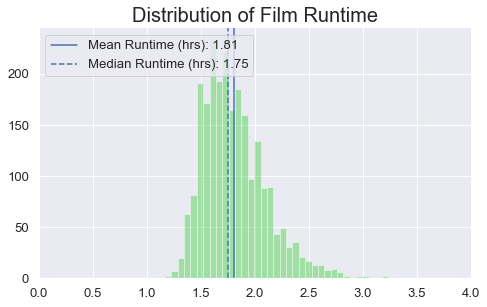

In [82]:
def plot_histogram(data, variable, title):
    mean = data.mean()
    median = np.median(data)
    plt.figure(figsize=(7,4.5))
    sns.set(font_scale=1.2,style='darkgrid' )
    ax = sns.distplot(data, kde=False, color='limegreen')
    ax.set(xlabel='', 
           ylabel='',
           xlim=(0.0,4.0)
           )
    ax.set_title(title,fontsize=20)
    axv1 = ax.axvline(mean, label='Mean %s: %3.2f'%(variable, mean))
    axv2 = ax.axvline(np.median(data), label='Median %s: %3.2f'%(variable, median), linestyle='--')
    ax.legend(loc='upper left')
    # Finalize the plot
    sns.despine(trim=True)
    plt.tight_layout(h_pad=2)

plot_histogram(df_movies[df_movies['runtime']>0]['runtime'], 'Runtime (hrs)', 'Distribution of Film Runtime')    

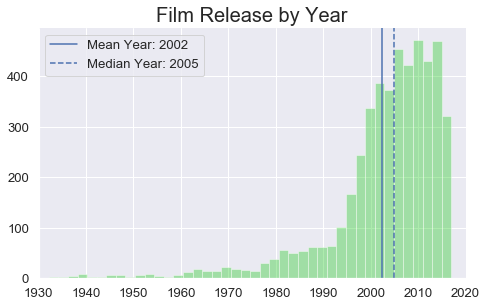

In [64]:
def plot_histogram(data, variable, title):
    mean = data.mean()
    median = np.median(data)
    plt.figure(figsize=(7,4.5))
    sns.set(font_scale=1.2,style='darkgrid' )
    ax = sns.distplot(data,bins=50, kde=False, color='limegreen')
    ax.set(xlabel='', 
           ylabel='',
           xlim=(1930,2020))
    ax.set_title(title,fontsize=20)
    axv1 = ax.axvline(mean, label='Mean %s: %4.0f'%(variable, mean))
    axv2 = ax.axvline(np.median(data), label='Median %s: %4.0f'%(variable, median), linestyle='--')
    ax.legend()
    # Finalize the plot
    sns.despine(trim=True)
    plt.tight_layout(h_pad=2)

plot_histogram(df_movies[df_movies['year']>0]['year'], 'Year', 'Film Release by Year')    

# Histogram of Films by Vote

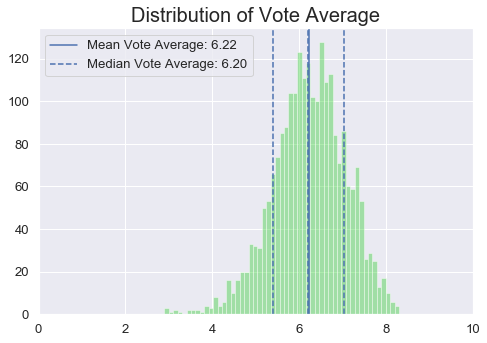

In [29]:
def plot_histogram(data, variable, title):
    # Calculate Descriptive Features
    mean = data.mean()
    median = np.median(data)
    st_dev = np.std(data)
    
    # Set Style of Histogram
    plt.figure(figsize=(7,5))
    sns.set(font_scale=1.2,style='darkgrid' )
    ax = sns.distplot(data, kde=False, color='limegreen', bins=53)
    
    # Set Label Names and Label Font
    ax.set(xlabel='', 
           ylabel='',
           xlim=(0,10))
    ax.set_title(title, fontsize=20)
    
    # Add Vertical Lines and Legend
    axv1 = ax.axvline(mean, label='Mean %s: %4.2f'%(variable, mean))
    axv2 = ax.axvline(median, label='Median %s: %4.2f'%(variable, median), linestyle='--')
    axv3 = ax.axvline((mean+st_dev), linestyle='--')
    axv4 = ax.axvline((mean-st_dev), linestyle='--')
    ax.legend()
    
    # Finalize the plot
    #sns.despine(trim=True)
    plt.tight_layout(h_pad=2)

plot_histogram(df_movies.vote_average, 'Vote Average', 'Distribution of Vote Average')    

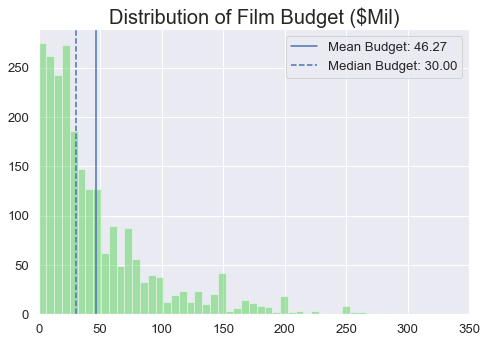

In [107]:
def plot_histogram(data, variable, title):
    # Calculate Descriptive Features
    mean = data.mean()
    median = np.median(data)
    st_dev = np.std(data)
    
    # Set Style of Histogram
    plt.figure(figsize=(7,5))
    sns.set(font_scale=1.2,style='darkgrid' )
    ax = sns.distplot(data, kde=False, color='limegreen', bins=60)
    
    # Set Label Names and Label Font
    ax.set(xlabel='', 
           ylabel=''
           ,xlim=(0,350)
          )
    ax.set_title(title, fontsize=20)
    
    # Add Vertical Lines and Legend
    axv1 = ax.axvline(mean, label='Mean %s: %4.2f'%(variable, mean))
    axv2 = ax.axvline(median, label='Median %s: %4.2f'%(variable, median), linestyle='--')
    ax.legend()
    
    # Finalize the plot
    #sns.despine(trim=True)
    plt.tight_layout(h_pad=2)

plot_histogram(df_movies.budget/1000000, 'Budget', 'Distribution of Film Budget ($Mil)')    

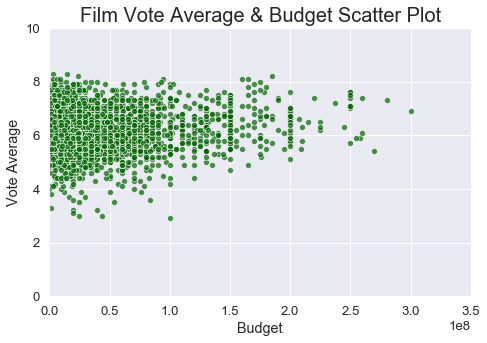

In [117]:
# Set Style of Histogram
plt.figure(figsize=(7,5))
sns.set(font_scale=1.2,style='darkgrid' )

ax = sns.scatterplot(y='vote_average', x='budget',color='darkgreen', data=df_movies, alpha=.7)
ax.set(xlabel='Budget', ylabel='Vote Average',
       ylim= (0,10),
       xlim=(0,350000000))
ax.set_title('Film Vote Average & Budget Scatter Plot', fontsize=20)
plt.tight_layout(h_pad=2)

plt.show()

## Histogram of Runtime

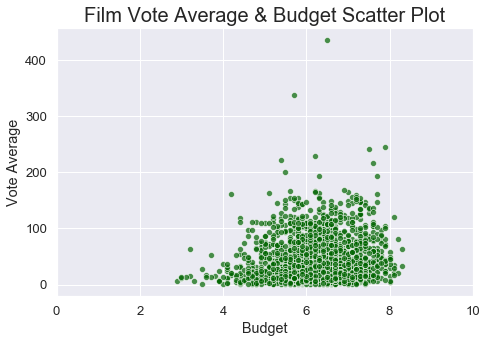

In [121]:
# Set Style of Histogram
plt.figure(figsize=(7,5))
sns.set(font_scale=1.2,style='darkgrid' )

ax = sns.scatterplot(yd='vote_average', y='total_employees',color='darkgreen', data=df_job, alpha=.7)
ax.set(xlabel='Budget', ylabel='Vote Average',
       xlim= (0,10))
ax.set_title('Film Vote Average & Total Employees', fontsize=20)
plt.tight_layout(h_pad=2)

plt.show()

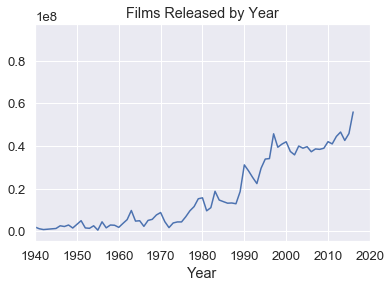

In [32]:
plt.plot(df_movies.groupby('year').mean()['budget'].astype('int'), label='Budget')
#plt.axvline(x=df_movies['year'].mean(), c='orange', label='')
plt.xlim(1940,2020)
plt.xlabel('Year')
#plt.ylabel('Films')
plt.title('Films Released by Year')
plt.show()

# Scatterplot Average Vote and Budget

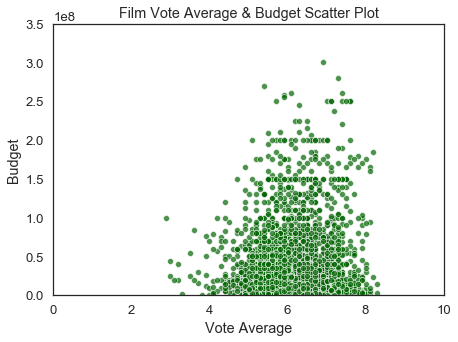

In [110]:
plt.figure(figsize=(7,5))
ax=sns.scatterplot(x='vote_average', y='budget', color='darkgreen', data=df_movies, alpha=.7)
ax.set(title='Film Vote Average & Budget Scatter Plot',
       ylabel='Budget', xlabel='Vote Average',
       xlim= (0,10),
       ylim=(0,350000000))
plt.show()

In [137]:
department_features = df_department.columns.unique()

In [200]:
order = df_stacked.groupby('department').count().sort_values(by='credit_id',ascending=False).index[:-1]

KeyboardInterrupt: 

<Figure size 1440x432 with 0 Axes>

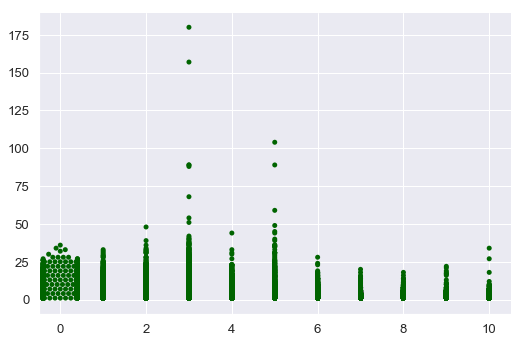

In [211]:
order=order
plot_types = ['swarm','violin', 'boxen', 'point', 'bar']

def plot_me(data, y, kind):
    plt.figure(figsize=(20,6))
    #sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth":1})
    g = sns.catplot(x="department", y=y, hue='vote_average', color='darkgreen',order=order, data=data, kind=kind, height=5, aspect=1.5)
    g.set_xlabels('')
    g.set_ylabels('Vote Average')

    g.set_xticklabels(order, rotation=45)
    plt.title('Distribution of Vote Average by Release Month')
    plt.show()


for x in plot_types:
    plot_me(df_stack, 'credit_id', 'swarm')

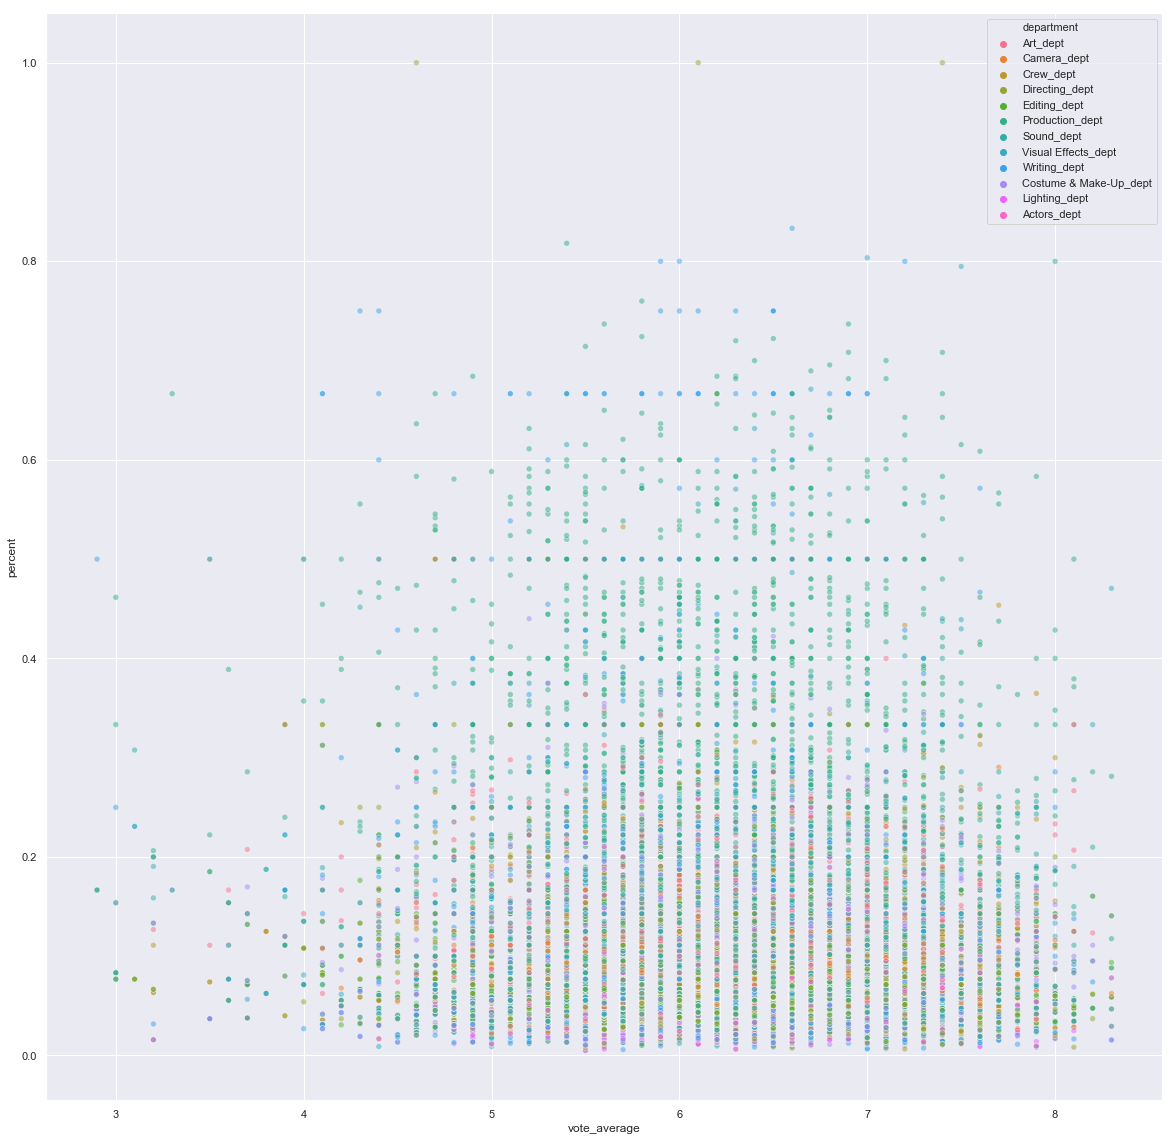

In [46]:
plt.figure(figsize=(20,20))
g = sns.scatterplot(y='percent', x='vote_average', data=df_stacked, hue='department', alpha= 0.5)

In [51]:
df_parsed.department.unique()

array(['Editing_dept', 'Art_dept', 'Sound_dept', 'Production_dept',
       'Directing_dept', 'Writing_dept', 'Visual Effects_dept',
       'Costume & Make-Up_dept', 'Camera_dept', 'Crew_dept',
       'Lighting_dept', 'Actors_dept'], dtype=object)

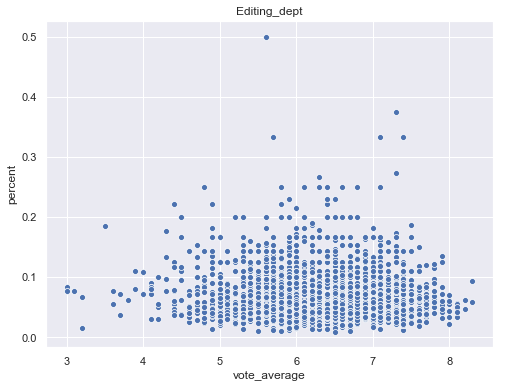

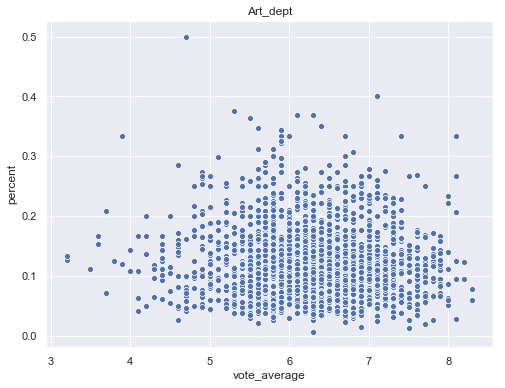

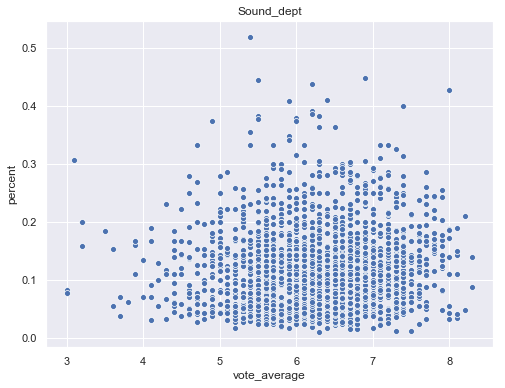

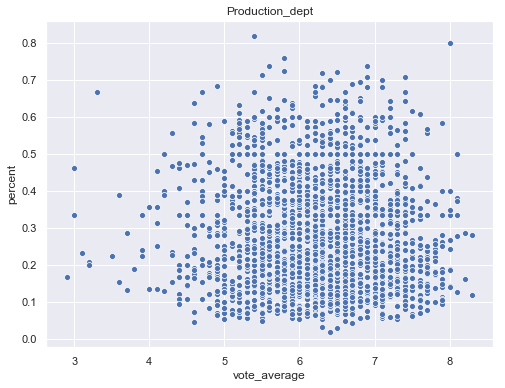

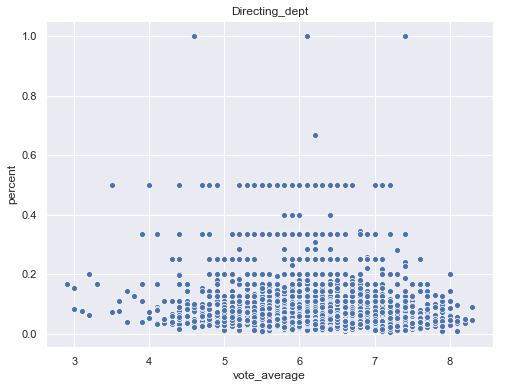

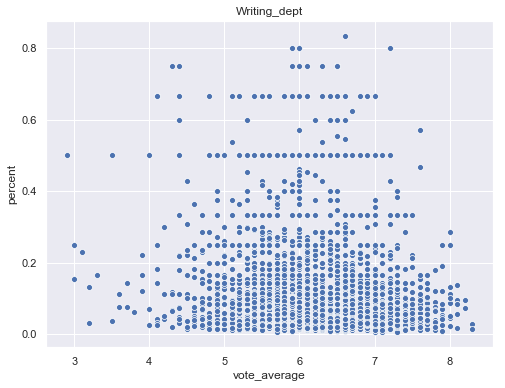

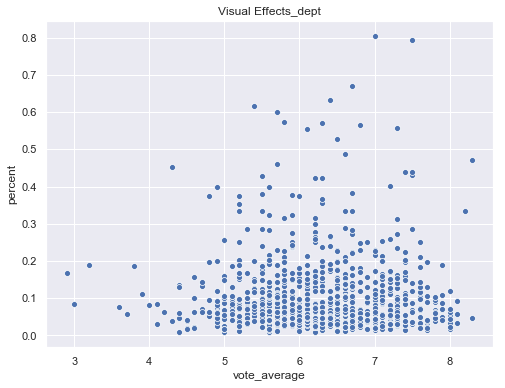

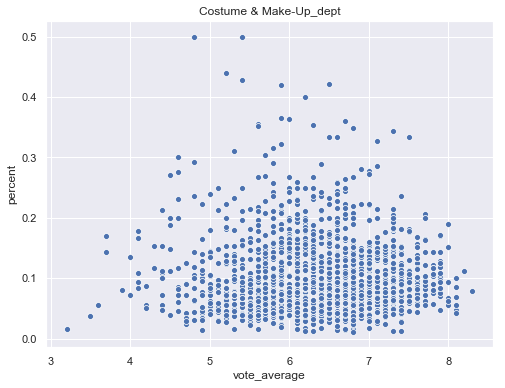

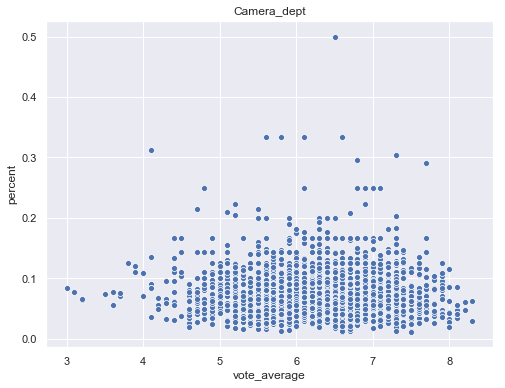

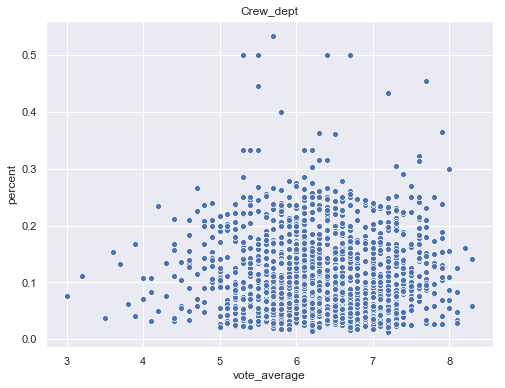

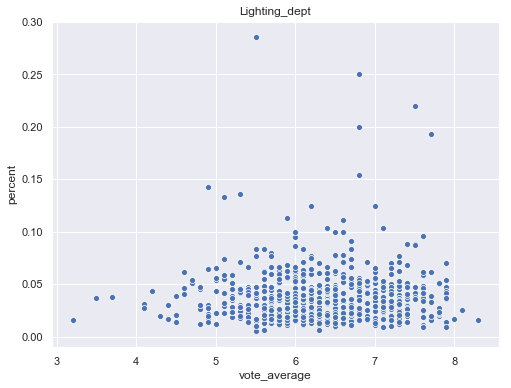

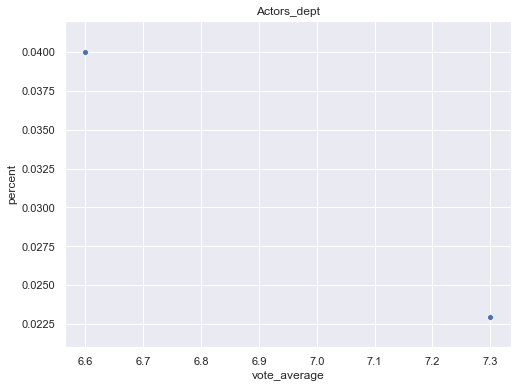

In [54]:
for x in df_parsed.department.unique():
    plt.figure(figsize=(8,6))
    g = sns.scatterplot(y='percent', x='vote_average', data=df_stacked[df_stacked['department']==x])
    g.set_title(x)

<Figure size 1080x432 with 0 Axes>

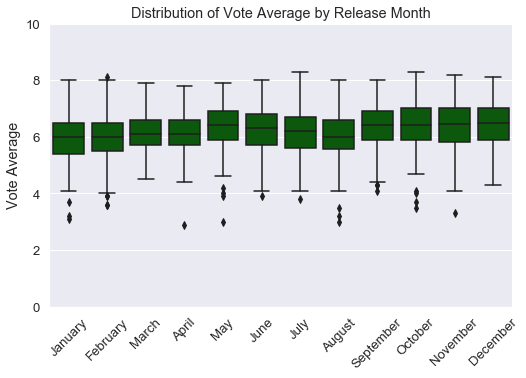

In [131]:
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'])
df_movies['month']=df_movies['release_date'].apply(lambda x: x.month_name())
order=['January','February','March','April','May','June','July', 'August', 'September', 'October', 'November', 'December']
#plot_types = ['swarm','violin', 'boxen', 'point', 'bar']

def plot_me(data, y, kind):
    plt.figure(figsize=(15,6))
    #sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth":1})
    g = sns.catplot(x="month", y=y, color='darkgreen',order=order, data=data, kind=kind, height=5, aspect=1.5)
    g.set_xlabels('')
    g.set_ylabels('Vote Average')
    g.set(ylim=(0,10))
    g.set_xticklabels(order, rotation=45)
    plt.title('Distribution of Vote Average by Release Month')
    plt.show()


plot_me(df_movies, 'vote_average', 'box')